In [43]:
import sys, torch, numpy as np

print("NumPy:", np.__version__)
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())


NumPy: 1.26.4
Torch: 2.7.1+cpu | CUDA: False


In [23]:
#GNN Drug Discovery pipeline

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error
import requests
import json
from tqdm import tqdm
import pickle
import os
from typing import List, Dict, Tuple, Optional
import re
import random
import io

#Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    project_dir = '/content/drive/MyDrive/GNN_Drug_Discovery'
except:
    project_dir = './GNN_Drug_Discovery'

os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/data', exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/results', exist_ok=True)


Using device: cpu


In [24]:
#Download DeepChem datasets
def download_real_datasets():
    datasets = {}

    #DeepChem dataset URLs
    urls = {
        'lipophilicity': 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv',
        'solubility': 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv',
        'bbb_permeability': 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv'
    }

    for name, url in urls.items():
        try:
            print(f"Downloading {name}...")
            response = requests.get(url, timeout=30)
            response.raise_for_status()

            df = pd.read_csv(io.StringIO(response.text))

            # Find target column
            target_col = None
            if name == 'lipophilicity' and 'exp' in df.columns:
                target_col = 'exp'
            elif name == 'solubility' and 'measured log solubility in mols per litre' in df.columns:
                target_col = 'measured log solubility in mols per litre'
            elif name == 'bbb_permeability' and 'p_np' in df.columns:
                target_col = 'p_np'

            if target_col:
                df = df[['smiles', target_col]].rename(columns={target_col: 'y'})
                df = df.dropna().drop_duplicates(subset=['smiles'])
                df.to_csv(f"{project_dir}/data/{name}.csv", index=False)
                datasets[name] = df
                print(f"{name}: {len(df)} samples")
            else:
                print(f"Could not find target column for {name}")

        except Exception as e:
            print(f"Failed to download {name}: {e}")

    return datasets

real_datasets = download_real_datasets()

if real_datasets:
    all_datasets = real_datasets
    print(f"Using {len(real_datasets)} real datasets")



lipophilicity: 4200 samples
solubility: 1128 samples
bbb_permeability: 2050 samples
Using 3 real datasets


In [25]:
#RDKit-Based Molecular Graph Builder

from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data

class RDKitMolecularGraphBuilder:
    """Builds molecular graphs with atom and bond features using RDKit."""

    def __init__(self):
        print("RDKit Molecular Graph Builder initialized")

    def get_atom_features(self, atom):
        """Extract atom-level features."""
        atomic_nums = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]  # H, C, N, O, F, P, S, Cl, Br, I
        atomic_num = atom.GetAtomicNum()

        features = []

        # One-hot encoding for atomic number
        for num in atomic_nums:
            features.append(1 if atomic_num == num else 0)

        # "Other" element category
        features.append(1 if atomic_num not in atomic_nums else 0)

        # Atom degree (number of directly bonded atoms)
        for deg in range(6):
            features.append(1 if atom.GetDegree() == deg else 0)

        # Formal charge (-2 to +2)
        for charge in range(-2, 3):
            features.append(1 if atom.GetFormalCharge() == charge else 0)

        # Aromaticity
        features.append(1 if atom.GetIsAromatic() else 0)

        # Ring membership
        features.append(1 if atom.IsInRing() else 0)

        # Normalized atomic mass
        features.append(atom.GetMass() / 100.0)

        return features

    def get_bond_features(self, bond):
        """Extract bond-level features."""
        bond_types = [
            Chem.rdchem.BondType.SINGLE,
            Chem.rdchem.BondType.DOUBLE,
            Chem.rdchem.BondType.TRIPLE,
            Chem.rdchem.BondType.AROMATIC,
        ]
        bond_type = bond.GetBondType()
        return [
            *[1 if bond_type == x else 0 for x in bond_types], # bond type
            1 if bond.GetIsConjugated() else 0,                # conjugation
            1 if bond.IsInRing() else 0                        # in ring
        ]

    def calculate_descriptors(self, mol):
        """Return molecular-level descriptors."""
        return [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
        ]

    def smiles_to_graph(self, smiles: str):
        """Convert a SMILES string to a PyTorch Geometric Data object."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        mol = Chem.AddHs(mol)

        # Atom features
        atom_features = [self.get_atom_features(atom) for atom in mol.GetAtoms()]
        x = torch.tensor(atom_features, dtype=torch.float)

        # Bond features
        edge_indices, edge_features = [], []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            feat = self.get_bond_features(bond)
            edge_indices += [[i, j], [j, i]]
            edge_features += [feat, feat]

        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)

        # Graph object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.graph_features = torch.tensor(self.calculate_descriptors(mol), dtype=torch.float)
        data.smiles = smiles
        return data

# Quick test
builder = RDKitMolecularGraphBuilder()
for smi in ["CCO", "c1ccccc1", "CC(=O)Oc1ccccc1C(=O)O"]:
    graph = builder.smiles_to_graph(smi)
    if graph:
        print(f"{smi}: {graph.x.shape[0]} atoms, {graph.edge_index.shape[1]} bonds")


RDKit Molecular Graph Builder initialized
CCO: 9 atoms, 16 bonds
c1ccccc1: 12 atoms, 24 bonds
CC(=O)Oc1ccccc1C(=O)O: 21 atoms, 42 bonds


In [27]:
# MOLECULAR GRAPH BUILDER

class SimpleMolecularGraphBuilder:
    """Build molecular graphs from SMILES using simple features"""

    def __init__(self):
        self.atom_vocab = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P', 'B']

    def smiles_to_features(self, smiles: str):
        """Extract comprehensive features from SMILES"""
        features = []

        # Basic composition
        features.append(len(smiles) / 100.0)  # Molecular length
        features.append((smiles.count('C') + smiles.count('c')) / 30.0)  # Carbon count
        features.append((smiles.count('N') + smiles.count('n')) / 10.0)  # Nitrogen count
        features.append((smiles.count('O') + smiles.count('o')) / 10.0)  # Oxygen count
        features.append((smiles.count('S') + smiles.count('s')) / 5.0)   # Sulfur count
        features.append((smiles.count('F') + smiles.count('Cl') + smiles.count('Br') + smiles.count('I')) / 5.0)  # Halogens

        # Ring and aromaticity
        features.append(sum(smiles.count(str(i)) for i in range(10)) / 10.0)  # Ring closures
        features.append(sum(1 for c in smiles if c.islower() and c.isalpha()) / 20.0)  # Aromatic atoms

        # Bond information
        features.append(smiles.count('=') / 10.0)  # Double bonds
        features.append(smiles.count('#') / 3.0)   # Triple bonds
        features.append(smiles.count('(') / 15.0)  # Branches
        features.append(smiles.count('[') / 5.0)   # Brackets
        features.append((smiles.count('+') + smiles.count('-')) / 3.0)  # Charges

        # Molecular weight estimate
        mw_estimate = ((smiles.count('C') + smiles.count('c')) * 12 +
                      (smiles.count('N') + smiles.count('n')) * 14 +
                      (smiles.count('O') + smiles.count('o')) * 16 +
                      (smiles.count('S') + smiles.count('s')) * 32)
        features.append(mw_estimate / 500.0)

        # LogP estimate
        logp_estimate = ((smiles.count('C') + smiles.count('c')) * 0.5 +
                        sum(1 for c in smiles if c.islower() and c.isalpha()) * 0.3 -
                        (smiles.count('N') + smiles.count('n')) * 0.7 -
                        (smiles.count('O') + smiles.count('o')) * 0.6)
        features.append(logp_estimate / 10.0)

        return torch.tensor(features, dtype=torch.float)

    def calculate_graph_features(self, smiles: str):
        """Additional graph-level features"""
        features = []

        # Complexity measures
        features.append(len(set(smiles)) / 20.0)  # Unique characters

        # Ring complexity
        ring_numbers = [c for c in smiles if c.isdigit()]
        max_ring = max([int(c) for c in ring_numbers]) if ring_numbers else 0
        features.append(max_ring / 9.0)

        # Heteroatom ratio
        total_atoms = sum(1 for c in smiles if c.isalpha())
        heteroatoms = sum(1 for c in smiles if c in 'NOSPFClBrI')
        hetero_ratio = heteroatoms / max(1, total_atoms)
        features.append(hetero_ratio)

        # Aromatic ratio
        aromatic_count = sum(1 for c in smiles if c.islower() and c.isalpha())
        aromatic_ratio = aromatic_count / max(1, total_atoms)
        features.append(aromatic_ratio)

        # Branching factor
        branch_ratio = smiles.count('(') / max(1, len(smiles))
        features.append(branch_ratio)
        # Ensure exactly 5 features
        assert len(features) == 5, f"Expected 5 features, got {len(features)}"
        return torch.tensor(features, dtype=torch.float)

    def create_pseudo_graph(self, smiles: str):
        """Create a pseudo-molecular graph"""
        # Single node with rich molecular features
        node_features = self.smiles_to_features(smiles).unsqueeze(0)

        # Self-loop
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        edge_attr = torch.tensor([[1.0]], dtype=torch.float)

        # Graph-level features
        graph_features = self.calculate_graph_features(smiles)

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        data.graph_features = graph_features
        data.smiles = smiles

        return data

# Create graph builder
graph_builder = SimpleMolecularGraphBuilder()

In [28]:
# MULTI-TASK GNN MODEL

class MultiTaskGNN(nn.Module):
    """Multi-task GNN for drug property prediction"""

    def __init__(self,
                 node_features: int = 15,
                 graph_features: int = 5,
                 hidden_dim: int = 128,
                 num_layers: int = 3,
                 dropout: float = 0.3,
                 use_attention: bool = True):
        super(MultiTaskGNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_attention = use_attention

        # Input projection
        self.node_proj = nn.Linear(node_features, hidden_dim)
        self.graph_proj = nn.Linear(graph_features, hidden_dim)

        # GNN layers
        self.gnn_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(num_layers):
            if use_attention:
                self.gnn_layers.append(
                    GATConv(hidden_dim, hidden_dim // 4, heads=4, dropout=dropout)
                )
            else:
                self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))

            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Global pooling
        self.pool = global_mean_pool

        # Shared representation
        self.shared_repr = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Task-specific heads
        self.task_heads = nn.ModuleDict({
            'lipophilicity': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'solubility': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'bbb_permeability': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 2)
            )
        })

        self.attention_weights = None

    def forward(self, data, task=None):
        """Forward pass"""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        graph_features = data.graph_features

        # Project input features
        x = F.relu(self.node_proj(x))

        # GNN layers
        for i, (gnn_layer, bn) in enumerate(zip(self.gnn_layers, self.batch_norms)):
            x_new = gnn_layer(x, edge_index)
            x_new = bn(x_new)
            x = F.relu(x_new) + x  # Residual connection
            x = F.dropout(x, training=self.training)

        # Global pooling
        node_repr = self.pool(x, batch)

        # Handle graph features - ensure proper dimensions
        if graph_features.dim() == 1:
            graph_features = graph_features.unsqueeze(0)

        # Ensure graph features are exactly 5 dimensions
        if graph_features.shape[-1] != 5:
            # Pad or truncate to exactly 5 features
            if graph_features.shape[-1] < 5:
                padding = torch.zeros(graph_features.shape[0], 5 - graph_features.shape[-1], device=graph_features.device)
                graph_features = torch.cat([graph_features, padding], dim=-1)
            else:
                graph_features = graph_features[:, :5]

        graph_repr = F.relu(self.graph_proj(graph_features))

        # Ensure same batch size
        if node_repr.size(0) != graph_repr.size(0):
            graph_repr = graph_repr.expand(node_repr.size(0), -1)

        combined_repr = torch.cat([node_repr, graph_repr], dim=1)

        # Shared representation
        shared_repr = self.shared_repr(combined_repr)

        # Task-specific predictions
        if task:
            return self.task_heads[task](shared_repr)
        else:
            predictions = {}
            for task_name, head in self.task_heads.items():
                predictions[task_name] = head(shared_repr)
            return predictions

In [29]:
#DATASET CLASS

class DrugDataset:
    """Dataset class for drug discovery tasks"""
    
    def __init__(self, datasets_dict, graph_builder):
        self.datasets = datasets_dict
        self.graph_builder = graph_builder
        self.task_names = list(datasets_dict.keys())
        
        # Create unified dataset
        self.unified_data = self._create_unified_dataset()
    
    def _create_unified_dataset(self):
        """Create unified dataset"""
        #Get all the unique SMILES
        all_smiles = set()
        for df in self.datasets.values():
            all_smiles.update(df['smiles'].tolist())
        
        #Choose 1500 for training
        selected_smiles = list(all_smiles)[:1500]
        
        unified_data = []
        for smiles in selected_smiles:
            entry = {'smiles': smiles}
            
            #Collect targets for each task
            for task_name in self.task_names:
                df = self.datasets[task_name]
                task_data = df[df['smiles'] == smiles]
                
                if len(task_data) > 0:
                    entry[f'{task_name}_target'] = task_data['y'].iloc[0]
                else:
                    entry[f'{task_name}_target'] = None
            unified_data.append(entry)

        return unified_data
    
    def create_data_loaders(self, train_size=0.8, val_size=0.1, batch_size=32):
        """Create data loaders"""
        #Convert to graphs
        graphs = []
        for entry in self.unified_data:
            try:
                graph = self.graph_builder.create_pseudo_graph(entry['smiles'])
                
                #Add task targets
                for task_name in self.task_names:
                    target_key = f'{task_name}_target'
                    if entry[target_key] is not None:
                        setattr(graph, target_key, torch.tensor([entry[target_key]], dtype=torch.float))
                    else:
                        setattr(graph, target_key, torch.tensor([float('nan')], dtype=torch.float))
                
                graphs.append(graph)
            except:
                continue
        
        # Split data
        n_total = len(graphs)
        n_train = int(train_size * n_total)
        n_val = int(val_size * n_total)
        
        indices = torch.randperm(n_total)
        train_indices = indices[:n_train]
        val_indices = indices[n_train:n_train + n_val]
        test_indices = indices[n_train + n_val:]
        
        train_graphs = [graphs[i] for i in train_indices]
        val_graphs = [graphs[i] for i in val_indices]
        test_graphs = [graphs[i] for i in test_indices]
        
        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
        
        print(f"Data split: {len(train_graphs)} train, {len(val_graphs)} val, {len(test_graphs)} test")
        
        return train_loader, val_loader, test_loader


In [40]:
# TRAINER CLASS

class MultiTaskTrainer:
    """Trainer for multi-task GNN"""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device

        self.loss_functions = {
            'lipophilicity': nn.MSELoss(),
            'solubility': nn.MSELoss(),
            'bbb_permeability': nn.CrossEntropyLoss()
        }

        self.task_weights = {
            'lipophilicity': 1.0,
            'solubility': 1.0,
            'bbb_permeability': 1.0
        }

        self.classification_tasks = {'bbb_permeability'}
        self.regression_tasks = {'lipophilicity', 'solubility'}

    def calculate_loss(self, predictions, targets):
        """Calculate multi-task loss"""
        total_loss = 0
        task_losses = {}

        for task_name in predictions.keys():
            pred = predictions[task_name]
            target = targets[task_name]

            if target.numel() == 0:
                continue

            if task_name in self.classification_tasks:
                target = target.long()
                loss = self.loss_functions[task_name](pred, target)
            else:
                loss = self.loss_functions[task_name](pred.squeeze(), target.float())

            weighted_loss = self.task_weights[task_name] * loss
            total_loss += weighted_loss
            task_losses[task_name] = loss.item()

        return total_loss, task_losses

# TRAINING FUNCTION

def train_multitask_model(model, trainer, train_loader, val_loader, num_epochs=50, lr=0.001):
    """Training loop"""
    print(" Starting Multi-Task Training")
    print("="*50)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        num_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            predictions = model(batch)

            # Prepare targets
            targets = {}
            for task_name in trainer.task_weights.keys():
                target = getattr(batch, f'{task_name}_target', None)
                if target is not None:
                    mask = ~torch.isnan(target)
                    if mask.sum() > 0:
                        targets[task_name] = target[mask]
                        predictions[task_name] = predictions[task_name][mask]
                    else:
                        del predictions[task_name]

            if len(targets) > 0:
                loss, task_losses = trainer.calculate_loss(predictions, targets)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

        avg_loss = epoch_loss / max(num_batches, 1)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                predictions = model(batch)

                targets = {}
                for task_name in trainer.task_weights.keys():
                    target = getattr(batch, f'{task_name}_target', None)
                    if target is not None:
                        mask = ~torch.isnan(target)
                        if mask.sum() > 0:
                            targets[task_name] = target[mask]
                            predictions[task_name] = predictions[task_name][mask]
                        else:
                            del predictions[task_name]

                if len(targets) > 0:
                    loss, _ = trainer.calculate_loss(predictions, targets)
                    val_loss += loss.item()
                    val_batches += 1

        avg_val_loss = val_loss / max(val_batches, 1)
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'{project_dir}/models/best_model.pth')

        # Logging
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch:3d}/{num_epochs}")
            print(f"  Train Loss: {avg_loss:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}")
            print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
            print()

        train_losses.append(avg_loss)

    print("Training completed")
    return train_losses

# EVALUATION FUNCTION

def evaluate_model(model, trainer, test_loader):
    """Evaluate model performance"""
    print(" Evaluating Model Performance")
    print("="*40)

    model.eval()
    all_predictions = {task: [] for task in trainer.task_weights.keys()}
    all_targets = {task: [] for task in trainer.task_weights.keys()}

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            predictions = model(batch)

            for task_name in predictions.keys():
                target = getattr(batch, f'{task_name}_target', None)
                if target is not None:
                    mask = ~torch.isnan(target)
                    if mask.sum() > 0:
                        pred = predictions[task_name][mask]
                        targ = target[mask]

                        if task_name in trainer.classification_tasks:
                            pred = F.softmax(pred, dim=1)[:, 1]
                        else:
                            pred = pred.squeeze()

                        all_predictions[task_name].extend(pred.cpu().numpy())
                        all_targets[task_name].extend(targ.cpu().numpy())

    #Calculate metrics
    results = {}
    for task_name in all_predictions.keys():
        if len(all_predictions[task_name]) > 0:
            pred = np.array(all_predictions[task_name])
            target = np.array(all_targets[task_name])

            if task_name in trainer.classification_tasks:
                pred_binary = (pred > 0.5).astype(int)
                acc = accuracy_score(target, pred_binary)
                auc = roc_auc_score(target, pred) if len(np.unique(target)) > 1 else 0.5
                results[task_name] = {'accuracy': acc, 'auc': auc}
                print(f"{task_name}: Accuracy = {acc:.3f}, AUC = {auc:.3f}")
            else:
                mse = mean_squared_error(target, pred)
                mae = mean_absolute_error(target, pred)
                r2 = np.corrcoef(target, pred)[0, 1] ** 2 if len(target) > 1 else 0
                results[task_name] = {'mse': mse, 'mae': mae, 'r2': r2}
                print(f"{task_name}: R² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {np.sqrt(mse):.3f}")

    return results

In [36]:
# VISUALIZATION FUNCTION

def plot_training_curves(train_losses):
    """Plot training curves"""
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses[-20:], 'r-', label='Last 20 Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss (Recent)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/results/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(model, trainer, test_loader):
    """Plot prediction results"""
    model.eval()
    all_predictions = {task: [] for task in trainer.task_weights.keys()}
    all_targets = {task: [] for task in trainer.task_weights.keys()}

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            predictions = model(batch)

            for task_name in predictions.keys():
                target = getattr(batch, f'{task_name}_target', None)
                if target is not None:
                    mask = ~torch.isnan(target)
                    if mask.sum() > 0:
                        pred = predictions[task_name][mask]
                        targ = target[mask]

                        if task_name in trainer.classification_tasks:
                            pred = F.softmax(pred, dim=1)[:, 1]
                        else:
                            pred = pred.squeeze()

                        all_predictions[task_name].extend(pred.cpu().numpy())
                        all_targets[task_name].extend(targ.cpu().numpy())

    # Plot results
    n_tasks = len([task for task in all_predictions.keys() if len(all_predictions[task]) > 0])
    if n_tasks == 0:
        return

    fig, axes = plt.subplots(1, min(3, n_tasks), figsize=(5*min(3, n_tasks), 4))
    if n_tasks == 1:
        axes = [axes]

    plot_idx = 0
    for task_name in all_predictions.keys():
        if len(all_predictions[task_name]) == 0 or plot_idx >= 3:
            continue

        ax = axes[plot_idx] if n_tasks > 1 else axes[0]
        pred = np.array(all_predictions[task_name])
        target = np.array(all_targets[task_name])

        if task_name in trainer.classification_tasks:
            # ROC curve for classification
            from sklearn.metrics import roc_curve
            if len(np.unique(target)) > 1:
                fpr, tpr, _ = roc_curve(target, pred)
                auc_score = roc_auc_score(target, pred)

                ax.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
                ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.set_title(f'{task_name.title()}\nROC Curve')
                ax.legend()
                ax.grid(True, alpha=0.3)
        else:
            #Scatter plot for regression
            ax.scatter(target, pred, alpha=0.6, s=30)

            #Perfect prediction line
            min_val = min(target.min(), pred.min())
            max_val = max(target.max(), pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

            #Metrics
            r2 = np.corrcoef(target, pred)[0, 1] ** 2 if len(target) > 1 else 0
            mae = mean_absolute_error(target, pred)
            ax.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            ax.set_xlabel('True Values')
            ax.set_ylabel('Predicted Values')
            ax.set_title(f'{task_name.title()}\nPredictions vs Truth')
            ax.grid(True, alpha=0.3)

        plot_idx += 1

    plt.tight_layout()
    plt.savefig(f'{project_dir}/results/prediction_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

In [44]:
# MAIN EXECUTION

def main():
    """Main execution function"""
    print("STARTING PIPELINE")
    print("="*60)

    # Display dataset information
    print(f"\nDATASET SUMMARY:")
    for name, df in all_datasets.items():
        print(f"   {name}: {len(df):,} molecules")
        if df['y'].dtype in ['float64', 'int64']:
            print(f"Range: {df['y'].min():.2f} to {df['y'].max():.2f}")
        else:
            print(f" Classes: {df['y'].value_counts().to_dict()}")

    # Test molecular graph creation
    print(f"\n TESTING MOLECULAR GRAPH CREATION:")
    test_smiles = list(all_datasets.values())[0]['smiles'].iloc[:3].tolist()
    for i, smiles in enumerate(test_smiles):
        try:
            graph = graph_builder.create_pseudo_graph(smiles)
            print(f"   Molecule {i+1}: {graph.x.shape[0]} nodes, {graph.x.shape[1]} features")
        except Exception as e:
            print(f"   Molecule {i+1}: Failed ({e})")

    # Create dataset and data loaders
    print(f"\nCREATING DATASET AND DATA LOADERS:")
    drug_dataset = DrugDataset(all_datasets, graph_builder)
    train_loader, val_loader, test_loader = drug_dataset.create_data_loaders(batch_size=32)

    # Create model
    print(f"\nCREATING MULTI-TASK GNN MODEL:")
    model = MultiTaskGNN(
        node_features=15,
        graph_features=5,
        hidden_dim=128,
        num_layers=3,
        dropout=0.3,
        use_attention=True
    )

    model = model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Model created with {total_params:,} parameters")
    print(f"   Tasks: {list(model.task_heads.keys())}")
    print(f"   Device: {device}")

    # Create trainer
    trainer = MultiTaskTrainer(model, device=device)

    # Training
    print(f"\n STARTING TRAINING:")
    train_losses = train_multitask_model(
        model, trainer, train_loader, val_loader,
        num_epochs=50, lr=0.001
    )

    # Evaluation
    print(f"\nEVALUATING MODEL:")
    results = evaluate_model(model, trainer, test_loader)

    # Visualization
    print(f"\nCREATING VISUALIZATIONS:")
    plot_training_curves(train_losses)
    plot_predictions(model, trainer, test_loader)

    # Summary
    print(f"\nPROJECT COMPLETED.")
    print("="*60)
    print(" Results visualized and saved")
    print(f" All files saved to: {project_dir}")

    print(f"\n RESULTS SUMMARY:")
    for task_name, metrics in results.items():
        print(f"{task_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.3f}")

    return model, trainer, results


STARTING PIPELINE

DATASET SUMMARY:
   lipophilicity: 4,200 molecules
Range: -1.50 to 4.50
   solubility: 1,128 molecules
Range: -11.60 to 1.58
   bbb_permeability: 2,050 molecules
Range: 0.00 to 1.00

 TESTING MOLECULAR GRAPH CREATION:
   Molecule 1: 1 nodes, 15 features
   Molecule 2: 1 nodes, 15 features
   Molecule 3: 1 nodes, 15 features

CREATING DATASET AND DATA LOADERS:


c:\Users\prach\Desktop\GNN_Drug_Discovery\venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Data split: 1200 train, 150 val, 150 test

CREATING MULTI-TASK GNN MODEL:
   Model created with 128,324 parameters
   Tasks: ['lipophilicity', 'solubility', 'bbb_permeability']
   Device: cpu

 STARTING TRAINING:
 Starting Multi-Task Training
Epoch   0/50
  Train Loss: 9.0897
  Val Loss: 14.1170
  Learning Rate: 1.00e-03



c:\Users\prach\Desktop\GNN_Drug_Discovery\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  10/50
  Train Loss: 4.7098
  Val Loss: 7.9015
  Learning Rate: 1.00e-03

Epoch  20/50
  Train Loss: 4.5092
  Val Loss: 7.5083
  Learning Rate: 1.00e-03

Epoch  30/50
  Train Loss: 4.0349
  Val Loss: 7.2422
  Learning Rate: 1.00e-03

Epoch  40/50
  Train Loss: 4.1394
  Val Loss: 9.2417
  Learning Rate: 5.00e-04

Epoch  49/50
  Train Loss: 3.7471
  Val Loss: 8.4382
  Learning Rate: 2.50e-04

Training completed

EVALUATING MODEL:
 Evaluating Model Performance
lipophilicity: R² = 0.258, MAE = 1.112, RMSE = 1.329
solubility: R² = 0.704, MAE = 1.579, RMSE = 1.998
bbb_permeability: Accuracy = 0.791, AUC = 0.768

CREATING VISUALIZATIONS:


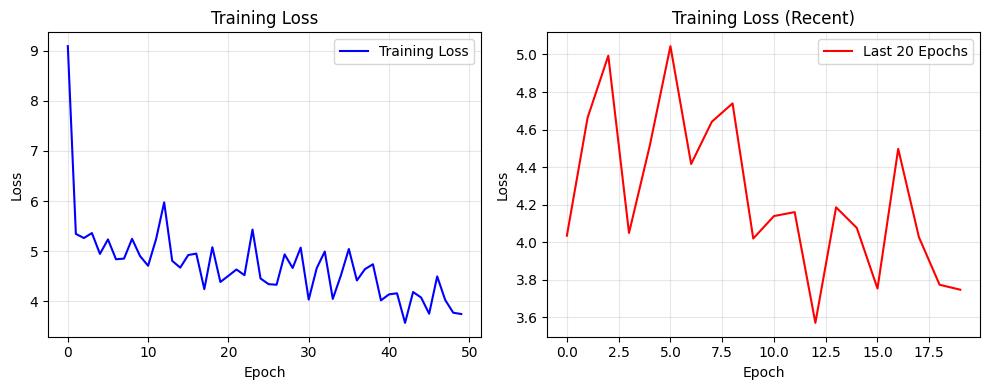

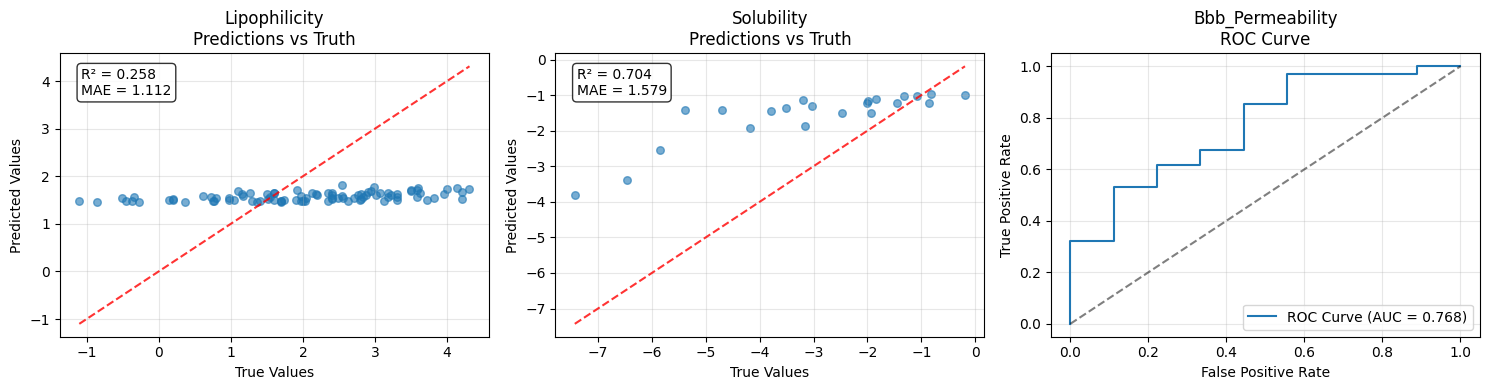


PROJECT COMPLETED.
 Results visualized and saved
 All files saved to: ./GNN_Drug_Discovery

 RESULTS SUMMARY:
lipophilicity:
mse: 1.766
mae: 1.112
r2: 0.258
solubility:
mse: 3.990
mae: 1.579
r2: 0.704
bbb_permeability:
accuracy: 0.791
auc: 0.768

Model and results saved to: ./GNN_Drug_Discovery


In [45]:
#  RUN THE COMPLETE PIPELINE

if __name__ == "__main__":
    # Execute the complete pipeline
    model, trainer, results = main()

    print(f"\nModel and results saved to: {project_dir}")